In [1]:
!pip install opencv-contrib-python==3.4.2.17

In [2]:
import cv2
print(cv2.__version__)

3.4.2


In [113]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics

from keras.preprocessing.image import ImageDataGenerator 

dir_train_images  = './data/training/'
dir_test_images   = './data/testing/'
dir_train_labels  = './data/labels_training.csv'
dir_test_ids      = './data/sample_submission.csv'

def load_data(dir_data, dir_labels, training=True):
    
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    filenames = []
    for identifier in ids:
        fname     = identifier.astype(str) + '.tif' 
        fpath     = dir_data + fname
        image     = mpl.image.imread(fpath)
        data.append(image)
        
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids
    
def cv_performance_assessment(X,y,k,clf):
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = preprocess_and_extract_features(X_train)
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = preprocess_and_extract_features(X_val)
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()

https://ianlondon.github.io/blog/how-to-sift-opencv/
    
https://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html

https://github.com/mayuri0192/Image-classification


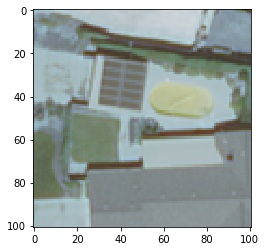

In [114]:
training_data, labels = load_data(dir_train_images, dir_train_labels, training=True)
spv_color0 = training_data[0]
spv_color1 = training_data[3]
plt.imshow(cv2.cvtColor(spv_color0, cv2.CV_32F))
plt.imshow(cv2.cvtColor(spv_color1, cv2.CV_32F))

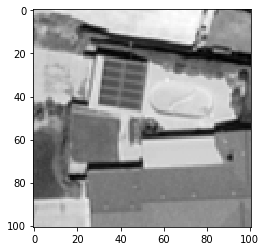

In [14]:
def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

spv_gray0 = to_gray(spv_color0)
spv_gray1 = to_gray(spv_color1)

plt.imshow(spv_gray0, cmap='gray');
plt.imshow(spv_gray1, cmap='gray');

In [6]:
def gen_sift_features(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

In [7]:
def show_sift_features(gray_img, color_img, kp):
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

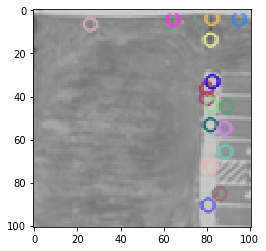

In [15]:
# generate SIFT keypoints and descriptors
spv_gray_kp0, spv_gray_desc0 = gen_sift_features(spv_gray0)
spv_gray_kp1, spv_gray_desc1 = gen_sift_features(spv_gray1)
show_sift_features(spv_gray0, spv_color0, spv_gray_kp0);

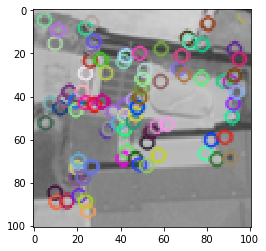

In [16]:
show_sift_features(spv_gray1, spv_color1, spv_gray_kp1);

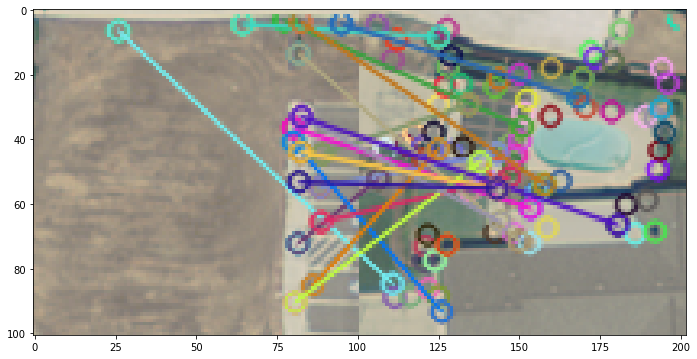

In [17]:
# create a BFMatcher object which will match up the SIFT features
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

matches = bf.match(spv_gray_desc0, spv_gray_desc1)

# Sort the matches in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# draw the top N matches
N_MATCHES = 100

match_img = cv2.drawMatches(
    spv_color0, spv_gray_kp0,
    spv_color1, spv_gray_kp1,
    matches[:N_MATCHES], spv_color1.copy(), flags=0)

plt.figure(figsize=(12,6))
plt.imshow(match_img);

In [21]:
def gen_sift_features(data):
    img_keypoints = {}
    img_descs = []

    for i in range(len(data)):
        gray = cv2.cvtColor(data[i], cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, desc = sift.detectAndCompute(gray, None)
        #img_keypoints[img_path] = kp
        img_descs.append(desc)
    print('SIFT descriptors generated.')
    
    return img_descs

In [22]:
image_training_desc = gen_sift_features(training_data)

SIFT descriptors generated.


In [68]:
len(image_training_desc[0][17])

IndexError: index 18 is out of bounds for axis 0 with size 18

In [37]:
def preprocess_and_extract_features(data):
    '''Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    '''
    # Here, we do something trivially simple: we take the average of the RGB
    # values to produce a grey image, transform that into a vector, then
    # extract the mean and standard deviation as features.
    
    # Make the image grayscale
    data = np.mean(data, axis=3)
    
    # Vectorize the grayscale matrices
    vectorized_data = data.reshape(data.shape[0],-1)
    
    # extract the mean and standard deviation of each sample as features
    feature_mean = np.mean(vectorized_data,axis=1)
    feature_std  = np.std(vectorized_data,axis=1)
    
    # Combine the extracted features into a single feature vector
    features = np.stack((feature_mean,feature_std),axis=-1)
    print(features.shape)
    return features

In [27]:
from sklearn import svm

In [115]:
def set_classifier():
    return svm.SVC(kernel='rbf', degree = 4, probability=True, C=1, gamma='scale')
    #return KNeighborsClassifier(n_neighbors=7)

In [120]:
def cv_performance_assessment(X,y,k,clf):
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = preprocess_and_extract_features(X_train)
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = preprocess_and_extract_features(X_val)
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

In [121]:
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()

In [125]:
def preprocess_and_extract_features(data):
    img_keypoints = {}
    features_all = []

    for i in range(len(data)):
        gray = cv2.cvtColor(data[i], cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SIFT_create()
        kp, desc = sift.detectAndCompute(gray, None)
        
        #img_keypoints[img_path] = kp
        desc_np = np.asarray(desc, dtype=np.float32)
        #print(desc_np.shape)
        try:
            feature_mean = desc_np.mean(axis=0, dtype=np.float32)
            #print(feature_mean.shape)
            feature_std  = desc_np.std(axis=0, dtype=np.float32)
            #print(feature_std.shape)
            #print(i)
            feature_com = np.hstack((feature_mean,feature_std))
        except:
            print('An error occured for index {}'.format(i))
            
        
        features_all.append(feature_com)
    print('SIFT descriptors generated.')
    # Combine the extracted features into a single feature vector
    return features_all

An error occured for index 775
SIFT descriptors generated.
SIFT descriptors generated.
An error occured for index 768
SIFT descriptors generated.
SIFT descriptors generated.
An error occured for index 782
SIFT descriptors generated.
SIFT descriptors generated.
SIFT descriptors generated.
An error occured for index 185
SIFT descriptors generated.
An error occured for index 767
SIFT descriptors generated.
SIFT descriptors generated.


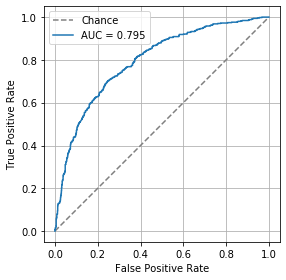

In [126]:
# Set parameters for the analysis
num_training_folds = 5

# Load the data
data, labels = load_data(dir_train_images, dir_train_labels, training=True)

# Choose which classifier to use
clf = set_classifier()

# Perform cross validated performance assessment
prediction_scores = cv_performance_assessment(data,labels,num_training_folds,clf)

# Compute and plot the ROC curves
plot_roc(labels, prediction_scores)

In [127]:
produce_submission = True # Switch this to True when you're ready to create a submission for Kaggle

if produce_submission:
    # Load data, extract features, and train the classifier on the training data
    training_data, training_labels = load_data(dir_train_images, dir_train_labels, training=True)
    training_features              = preprocess_and_extract_features(training_data)
    clf                            = set_classifier()
    clf.fit(training_features,training_labels)

    # Load the test data and test the classifier
    test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
    test_features  = preprocess_and_extract_features(test_data)
    test_scores    = clf.predict_proba(test_features)[:,1]

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores})
    submission_file.to_csv('submission_svm.csv',
                           columns=['id','score'],
                           index=False)

An error occured for index 969
SIFT descriptors generated.
SIFT descriptors generated.


array([13.66666667,  5.33333333,  3.        ,  4.        ])

In [102]:
import numpy
numpy.set_printoptions(threshold=10000)